In [120]:
%run setup.py

In [135]:
stars = pd.read_excel(rootpath+'sample/samples.xlsx')
kics = [8590931] 
idx = ( (stars['ifmodelling']==1) \
    & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) \
    & np.isfinite(stars['[M/H]']) & (~np.isin(stars['KIC'], kics)))

stars = stars.loc[idx,:]

In [136]:
idx = ~np.isfinite(stars['Dnu'])
stars.loc[idx, 'Dnu'] = stars.loc[idx, 'Dnu_guess']

In [137]:
def retrieve_best_data_to_table(table, filepath, tcols, dcols):
    Ncol = len(tcols)
    for istar, star in table.iterrows():
        for icol in range(Ncol):
            file = filepath.format(star['KIC'])
            if not os.path.exists(file): continue
            data=ascii.read(file, delimiter=',')
            table.loc[istar, tcols[icol]] = data[dcols[icol]][2]
    return table

data_cols = ['surf_corr_at_numax', 'log_g', 'Teff', 'FeH']
table_cols = ['surf_corr_best', 'log_g_best', 'Teff_best', 'FeH_best']

data_col_names = data_cols
table_col_names = [t for t in table_cols]
filepath = rootpath+'hpc/results_cubic/{:09.0f}/summary_best.txt'
stars = retrieve_best_data_to_table(stars, filepath, table_col_names, data_col_names)

stars['g_best'] = 10.0**stars['log_g_best']/27400

In [131]:
data = ascii.read(rootpath+'hpc/results_cubic/{:09.0f}/summary_best.txt'.format(0))
data

best_model_by,chi2,chi2_nonseis,chi2_seis,index,star_age,star_mass,luminosity,radius,Teff,Yinit,Xinit,Zinit,log_g,amlt,FeH,delta_nu_scaling,numax_scaling,acoustic_cutoff,profile_number,Dnu_freq,surf_a3,surf_corr_at_numax,Dnu_freq_sc
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
chi2,0.9285279021152015,0.6278348772790195,0.30069302483618204,8039.0,7026853376.573156,0.91782,0.9981685921764976,0.9710345634462841,5854.775020265289,0.28385193,0.70355151,0.01259657,4.426355767056679,2.20777,-0.006032073236551305,135.26395278955337,2987.739283527815,2987.739283527815,83.0,135.75910188626798,-2.6732688175998708e-08,-3.7796395939065137,134.95705131901877
chi2_nonseis,296.59010520528176,0.03927466830658242,296.5508305369752,5623.0,3517708393.4575305,1.05259,1.0028519224972576,1.0036515757643618,5765.597196605275,0.22845642,0.75766575,0.01387783,4.457160925460305,2.05567,0.003853122420452104,137.85118784190067,3232.070403949794,3232.070403949794,46.0,138.02177036929766,-3.2373008432333057e-07,-35.285335079695535,129.7772178572057
chi2_seis,18.768813113921805,18.722825060679014,0.045988053242789234,1447.0,6342719934.258226,0.92729,0.9370878110853762,0.9746392418866258,5752.408322936623,0.30553772,0.67717447,0.01728781,4.427595416850331,1.998846,0.148049748543579,135.2064148385966,3022.8221769118545,3022.8221769118545,73.0,135.8802440971945,-3.60451808772814e-08,-4.536156804883412,134.88885812295726


In [138]:
cols = ['Teff_best', 'g_best', 'FeH_best', 'surf_corr_best']
idx = stars.index>-1
for col in cols:
    idx = idx & np.isfinite(stars[col])
stars = stars.loc[idx,:].reset_index(drop=True)

0

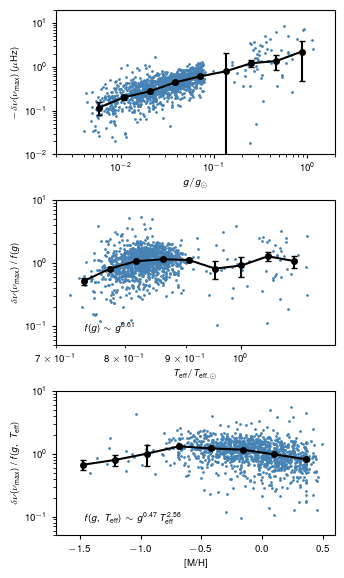

In [140]:
from sklearn.linear_model import LinearRegression


fig, axes = plt.subplots(figsize=mnras_size(ratio=1.7,column='one'), nrows=3, ncols=1, 
                         squeeze=False, constrained_layout=True) #gridspec_kw={'hspace':0.3}) #, gridspec_kw={'wspace':0.5,'hspace':0.5}
axes = axes.reshape(-1)


# sunstyle = {'marker':'$\\odot$', 's':msize+32, 'edgecolor':'k', 'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha, 'norm':norm}
styles = {'marker':'.', 'c':blue, 's':4,}
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}

sun = np.isin(stars['names'],['Sun'])
allstar = np.isin(stars['stage'],['rgb','lsg','esg','ms']) & (~sun)


axes[0].scatter(stars.loc[allstar, 'g_best'], -stars.loc[allstar, 'surf_corr_best'], **styles)
a = stars.loc[allstar, 'g_best']
b = -stars.loc[allstar, 'surf_corr_best']
xcs, medians, stds = se.get_binned_median(a, b, np.logspace(np.log10(min(a)), np.log10(max(a)), num=10, base=10))
axes[0].errorbar(xcs, medians, yerr=stds, **estyles)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$g/g_\\odot$')
axes[0].set_ylabel('$-\\delta\\nu(\\nu_{\\rm max})$  ($\\mu$Hz)')
axes[0].set_ylim(1*10**-2, 2*10**1)
axes[0].set_xlim(0.002, 2.)


idx = allstar & (stars['surf_corr_best']<0)
X = np.log10(stars.loc[idx, ['g_best']].to_numpy())
y = np.log10(-stars.loc[idx, 'surf_corr_best'].to_numpy())
lr = LinearRegression() 
lr.fit(X,y)
ypred = lr.predict(X)
s='{:0.2f}'.format(lr.coef_[0])
axes[1].text(0.1, 0.1, '$f(g) \\sim g^{'+s+'}$', \
             transform=axes[1].transAxes)
axes[1].scatter(stars.loc[idx,'Teff']/5777., 10.0**y/10.0**ypred, **styles)
a = stars.loc[idx,'Teff']/5777.
b = 10.0**y/10.0**ypred
xcs, medians, stds = se.get_binned_median(a, b, np.logspace(np.log10(min(a)), np.log10(max(a)), num=10, base=10))
axes[1].errorbar(xcs, medians, yerr=stds, **estyles)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$T_{\\rm eff}/T_{\\rm eff, \\odot}$')
axes[1].set_ylabel('$\\delta\\nu(\\nu_{\\rm max})$ / $f(g)$')
axes[1].set_ylim(0.05, 10)
axes[1].set_xlim(0.7, 1.2)



idx = allstar & (stars['surf_corr_best']<0)
X = stars.loc[idx, ['g_best', 'Teff']].to_numpy()
X[:,0] = np.log10(X[:,0])
X[:,1] = np.log10(X[:,1]/5777.)
y = np.log10(-stars.loc[idx, 'surf_corr_best'].to_numpy())
lr = LinearRegression() 
lr.fit(X,y)
ypred = lr.predict(X)
s1, s2 ='{:.2f}'.format(lr.coef_[0]), '{:.2f}'.format(lr.coef_[1])
axes[2].text(0.1, 0.1, '$f(g,\ T_{\\rm eff}) \\sim g^{'+s1+'} \ T_{\\rm eff}^{'+s2+'}$', \
             transform=axes[2].transAxes)
axes[2].scatter(stars.loc[idx,'[M/H]'], 10.0**y/10.0**ypred, **styles)
a = stars.loc[idx,'[M/H]']
b = 10.0**y/10.0**ypred
xcs, medians, stds = se.get_binned_median(a, b, np.linspace(min(a), max(a), 10))
axes[2].errorbar(xcs, medians, yerr=stds, **estyles)
axes[2].set_yscale('log')
axes[2].set_xlabel('[M/H]')
axes[2].set_ylabel('$\\delta\\nu(\\nu_{\\rm max})$ / $f(g,\ T_{\\rm eff})$')
axes[2].set_ylim(0.05, 10)
axes[2].set_xlim(-1.7, 0.6)


# plt.tight_layout()
filename = 'Fig.2_surf_corr.pdf'

plt.savefig(filename)
os.system(to_overleaf(filename))